# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

import liesel_gam as gam

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

In [3]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths with clear anisotropy.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True anisotropic smooth ----
    def f_true(x, y):
        # 1) Fast variation in x, slow in y
        term1 = 1.5 * np.sin(6 * np.pi * x) * np.cos(1 * np.pi * y)

        # 2) Anisotropic Gaussian bump: elongated + rotated
        x0, y0 = 0.65, 0.35
        a_x, a_y = 0.10, 0.35  # different length scales: much tighter in x
        rho = 0.7  # correlation -> rotated ellipse

        X = x - x0
        Y = y - y0
        quad = (X**2) / (a_x**2) + (Y**2) / (a_y**2) + 2 * rho * X * Y / (a_x * a_y)
        term2 = 2.0 * np.exp(-quad)

        # 3) Mild linear trend (mainly in y for additional anisotropy)
        term3 = 0.5 * y

        return term1 + term2 + term3

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [4]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.534281  0.287991
1  0.438878  0.761433 -0.434527 -0.649737
2  0.858598  0.903328  1.107858  1.722214
3  0.697368  0.720696  0.093873  0.544309
4  0.094177  0.963211 -0.977369 -1.080306


In [5]:
df_grid = gen_tp_data(n=5000, grid=True)

In [6]:
df_grid

,x,y,eta,z
0,0.000000,0.0,3.678865e-23,0.103675
1,0.014286,0.0,3.990553e-01,0.645541
2,0.028571,0.0,7.693489e-01,0.868480
3,0.042857,0.0,1.084192e+00,0.693245
4,0.057143,0.0,1.320893e+00,1.592500
...,...,...,...,...
5036,0.942857,1.0,1.820893e+00,1.616454
5037,0.957143,1.0,1.584192e+00,1.591152
5038,0.971429,1.0,1.269349e+00,1.251839
5039,0.985714,1.0,8.990553e-01,0.794860


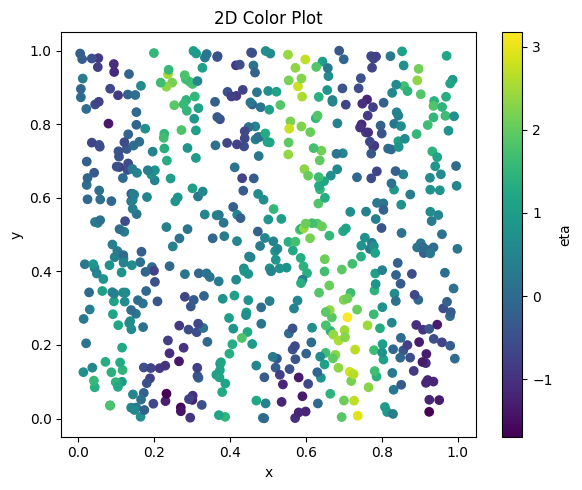

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

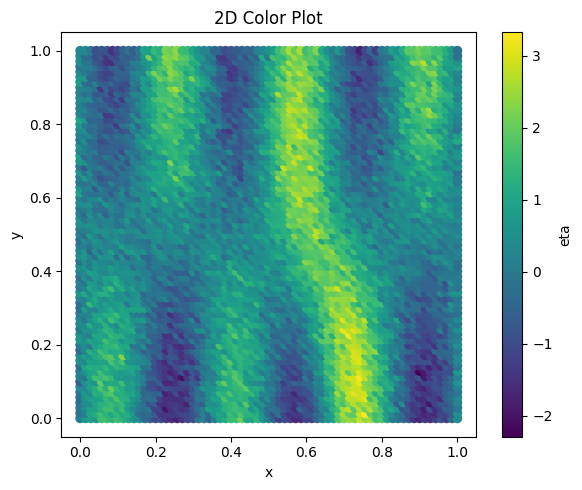

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

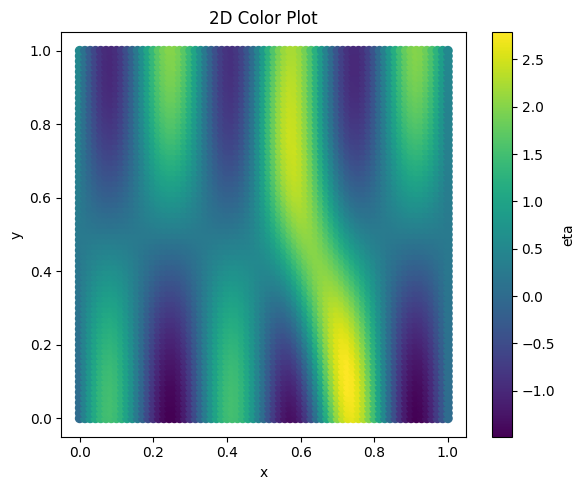

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [10]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [11]:
tb = gam.TermBuilder.from_df(df)

In [12]:
psx = tb.ps("x", k=12, inference=gs.MCMCSpec(gs.IWLSKernel.untuned))
psy = tb.ps("y", k=12, inference=gs.MCMCSpec(gs.IWLSKernel.untuned))
loc += tb.tf(psx, psy)

### Build and plot model

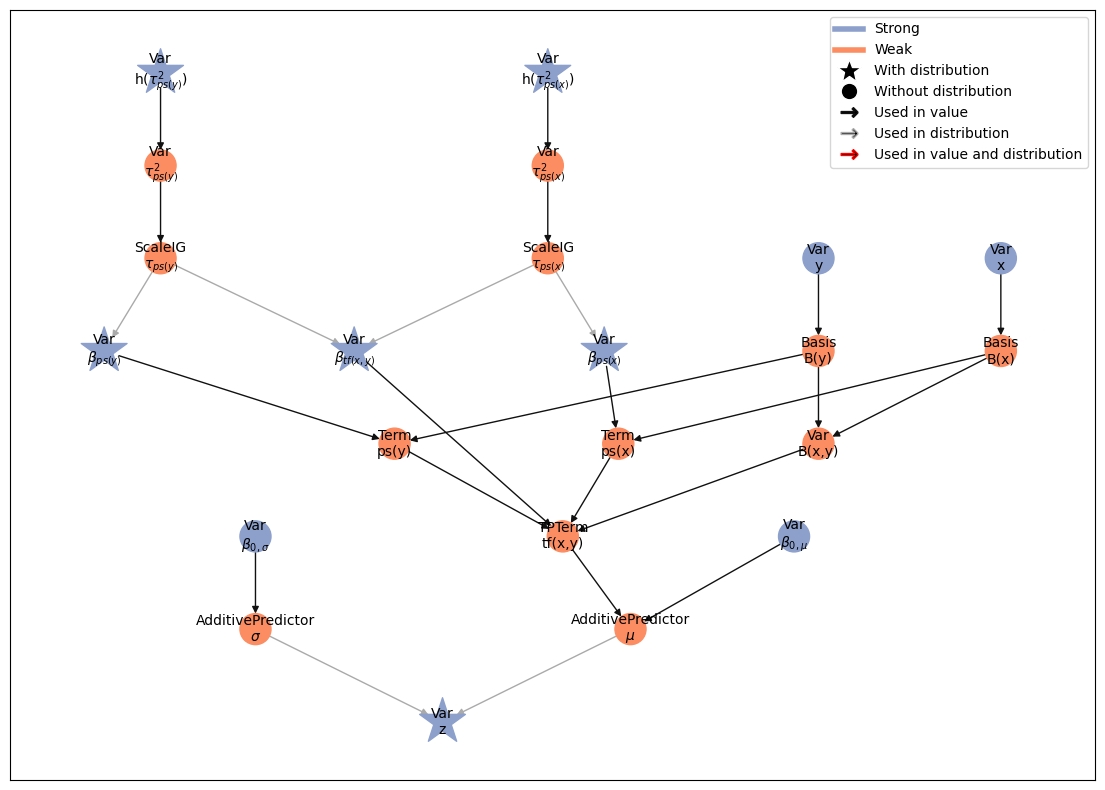

In [13]:
model = lsl.Model([z], to_float32=False)
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [14]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=3000,
        posterior_duration=2000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{tf(x,y)}$', 'h($\\tau^2_{ps(y)}$)', 'h($\\tau^2_{ps(x)}$)', '$\\beta_{ps(y)}$', '$\\beta_{ps(x)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:08<00:00,  1.01s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 21, 16, 19, 17 / 200 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 1, 2, 2, 1 / 200 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 625.46chunk/s]
liesel.goose.engine - WARNING - Err

### MCMC summary

In [15]:
summary = gs.Summary(results)

diagnostics = (
    summary.to_dataframe()
    .reset_index()
    .loc[:, ["variable", "rhat", "ess_bulk", "ess_tail"]]
    .groupby("variable", as_index=False)
    .agg(
        ess_bulk_min=("ess_bulk", "min"),
        ess_bulk_median=("ess_bulk", "median"),
        ess_tail_min=("ess_tail", "min"),
        ess_tail_median=("ess_tail", "median"),
        rhat_max=("rhat", "max"),
        rhat_median=("rhat", "median"),
    )
)
diagnostics

,variable,ess_bulk_min,ess_bulk_median,ess_tail_min,ess_tail_median,rhat_max,rhat_median
0,"$\beta_{0,\mu}$",1277.638311,1277.638311,1573.647789,1573.647789,1.000480,1.000480
1,"$\beta_{0,\sigma}$",1252.693730,1252.693730,1523.891222,1523.891222,1.000117,1.000117
2,$\beta_{ps(x)}$,722.991069,905.861670,1177.255331,1345.421779,1.002172,1.000915
3,$\beta_{ps(y)}$,652.116733,1076.721107,1028.105923,1284.074156,1.003634,1.002483
4,"$\beta_{tf(x,y)}$",178.827297,470.073816,322.595926,749.348551,1.022325,1.005248
5,h($\tau^2_{ps(x)}$),1682.972097,1682.972097,1341.919432,1341.919432,1.003597,1.003597
6,h($\tau^2_{ps(y)}$),83.928659,83.928659,120.164492,120.164492,1.016010,1.016010


In [16]:
[n for n in model.parameters if "tau" in n]

['h($\\tau^2_{ps(y)}$)', 'h($\\tau^2_{ps(x)}$)']

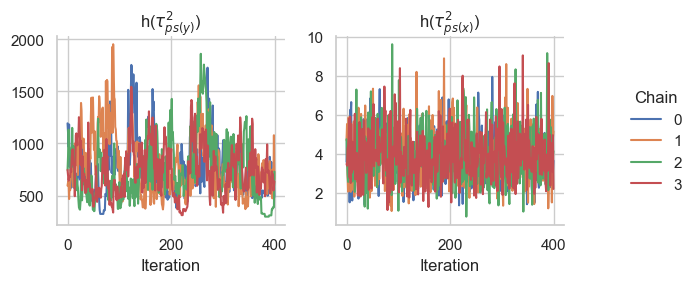

In [17]:
gs.plot_trace(results, [n for n in model.parameters if "tau" in n])

In [18]:
samples = results.get_posterior_samples()

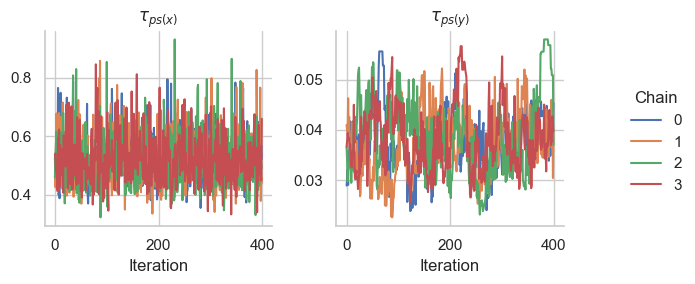

In [19]:
gs.plot_trace(
    model.predict(samples, predict=[s.name for s in model.vars["tf(x,y)"].scales])
)

### MCMC trace plots

## Predictions

In [20]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [21]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["tf(x,y)", "$\\mu$"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0

In [22]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [23]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x,y
0,$\mu$,$\mu$[0],"(0,)",1600,0.199929,0.500057,0.707147,287.347855,651.569549,0.041793,0.020417,1.002126,-1.007298,0.199869,1.319204,-0.936592,1.363409,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",1600,0.589549,0.300065,0.547782,276.064393,530.448083,0.033040,0.015803,1.003081,-0.341787,0.593971,1.477181,-0.408051,1.401394,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",1600,0.939370,0.190016,0.435908,273.683485,495.207443,0.026381,0.012407,1.003754,0.210259,0.946508,1.652315,0.208708,1.652080,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",1600,1.235092,0.127483,0.357047,283.726705,594.793300,0.021209,0.009888,1.005761,0.638236,1.243089,1.814446,0.648046,1.820390,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",1600,1.463918,0.088632,0.297711,300.042711,679.259429,0.017172,0.007984,1.003371,0.968359,1.475081,1.946433,0.993073,1.971885,0.057143,0.0


### Plot fitted functions

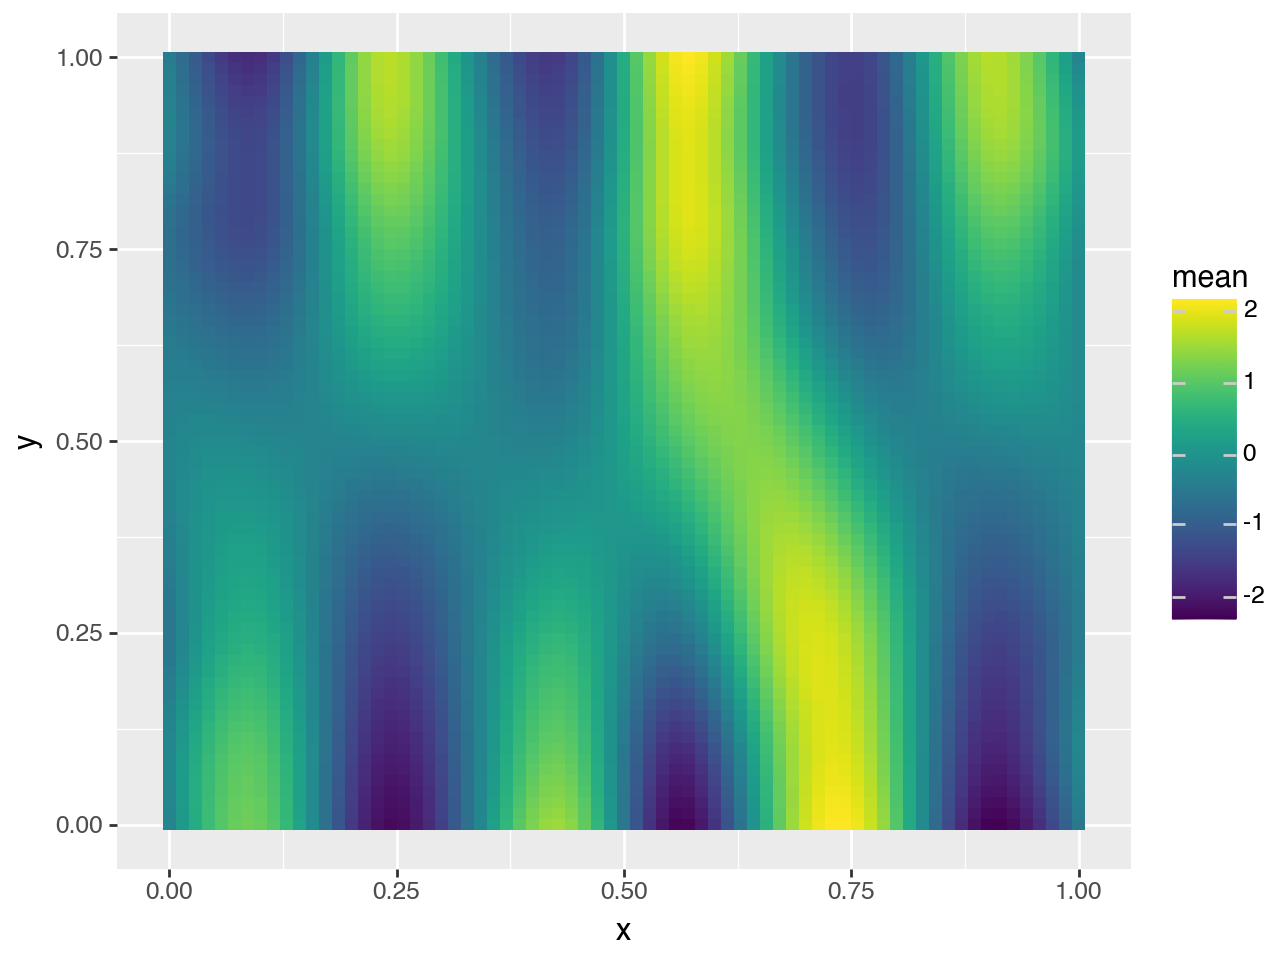

In [24]:
select = predictions_summary["variable"].isin(["tf(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

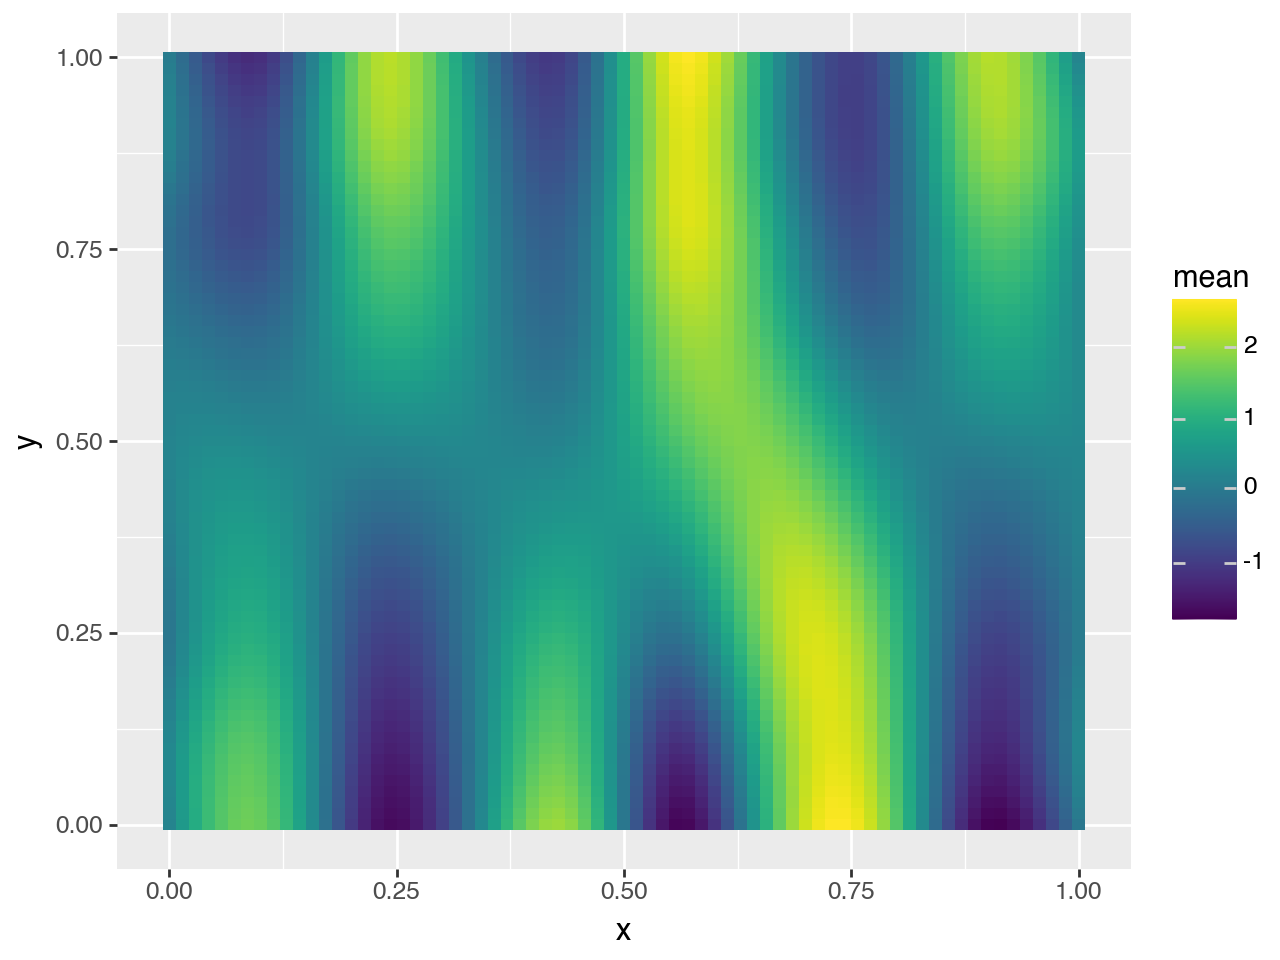

In [25]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

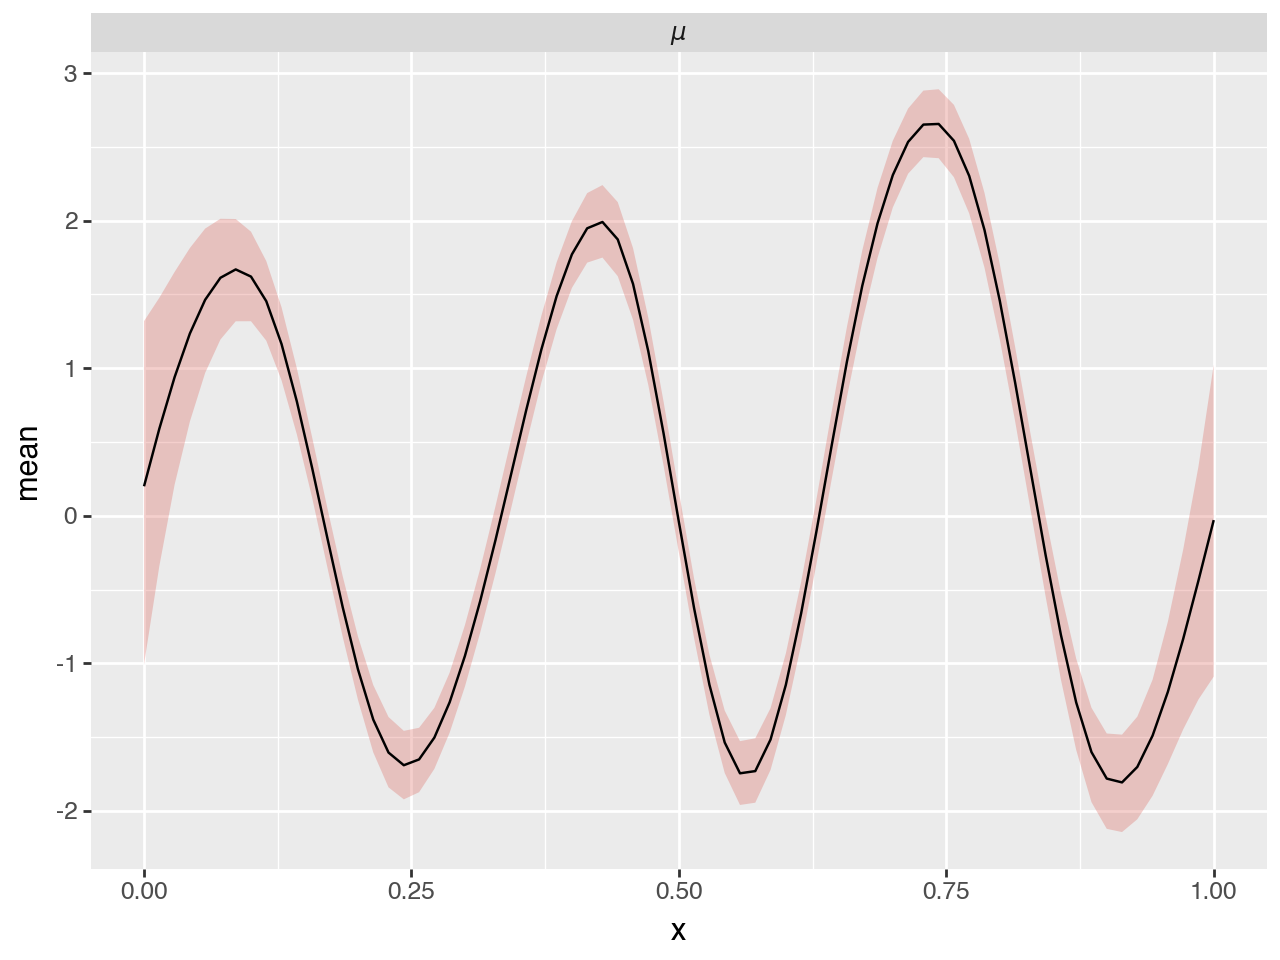

In [26]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select].query("y == 0.0"))
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

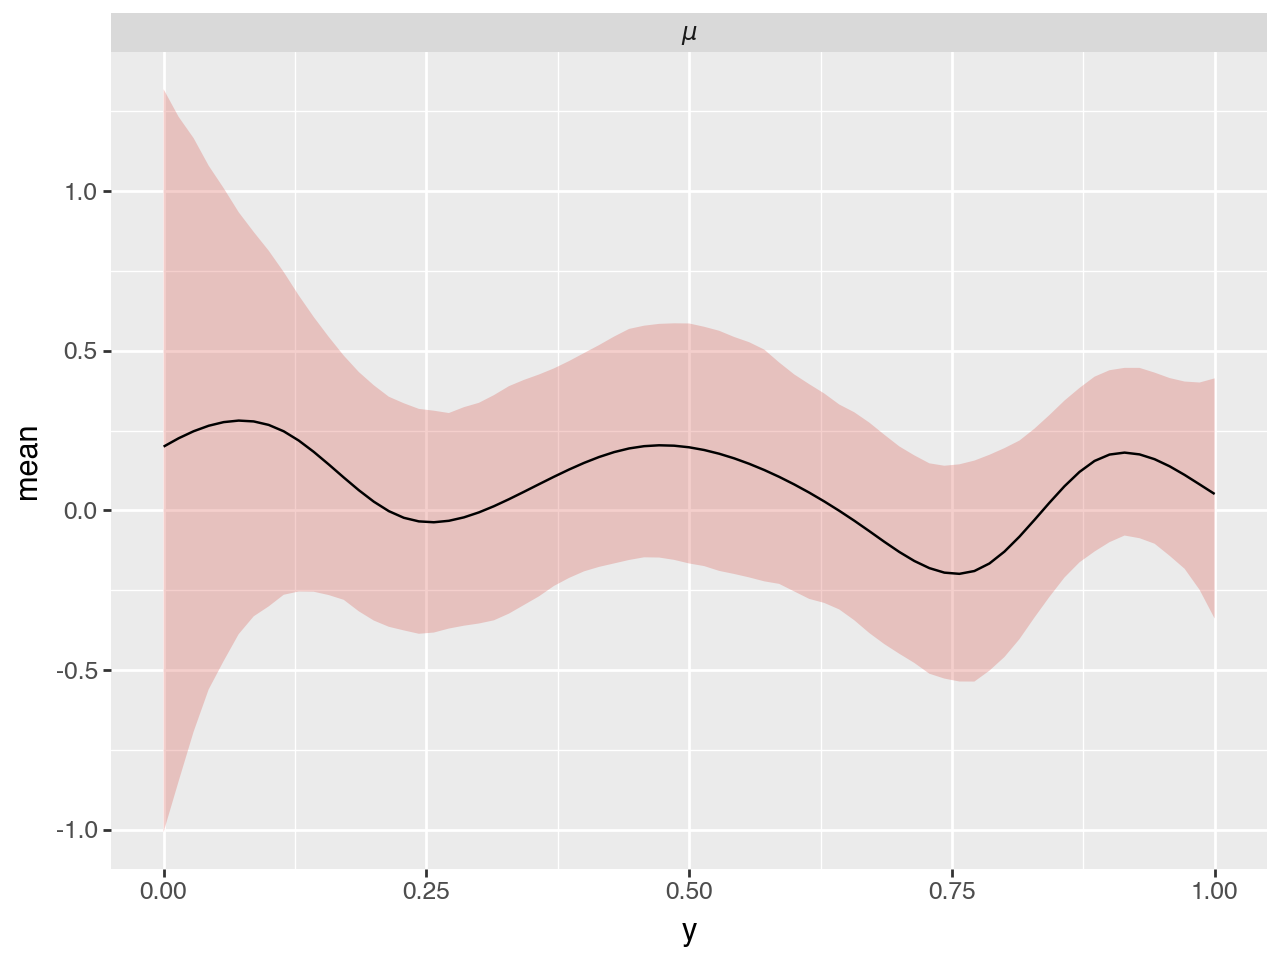

In [27]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select].query("x == 0.0"))
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)